In [25]:
import itertools
import time
import pandas as pd
import numpy as np
import math
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import shap

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# Import data

In [3]:
data = pd.read_csv('../../data/train_airbnb_berlin_preprocessed.csv', delimiter = ';')

# Prepare data for linear regression

In [4]:
# Now that we have extracted all the gender info from 'Host Name' we delete the feature
del data['Host Name']

# All the information in 'Postal Code' is in 'Longitude', 'Latitude', 'neighborhood' and 'Neighborhood Group'
del data['Postal Code']

# Just for now
del data['neighbourhood']

In [5]:
# We encode 'Neighborhood Group' classes into a one hot encoder
data = pd.get_dummies(data, columns=['Neighborhood Group'], dtype = 'int64')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15268 entries, 0 to 15267
Data columns (total 59 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Host Since                                   15268 non-null  int64  
 1   Host Response Rate                           15268 non-null  float64
 2   Is Superhost                                 15268 non-null  int64  
 3   Latitude                                     15268 non-null  float64
 4   Longitude                                    15268 non-null  float64
 5   Is Exact Location                            15268 non-null  int64  
 6   Accomodates                                  15268 non-null  int64  
 7   Bathrooms                                    15268 non-null  float64
 8   Bedrooms                                     15268 non-null  float64
 9   Beds                                         15268 non-null  float64
 10

In [7]:
data.describe()

,Host Since,Host Response Rate,Is Superhost,Latitude,Longitude,Is Exact Location,Accomodates,Bathrooms,Bedrooms,Beds,...,Neighborhood Group_Lichtenberg,Neighborhood Group_Marzahn - Hellersdorf,Neighborhood Group_Mitte,Neighborhood Group_NeukÃ¶lln,Neighborhood Group_Pankow,Neighborhood Group_Reinickendorf,Neighborhood Group_Spandau,Neighborhood Group_Steglitz - Zehlendorf,Neighborhood Group_Tempelhof - SchÃ¶neberg,Neighborhood Group_Treptow - KÃ¶penick
count,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,...,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.00000,15268.000000
mean,1488.516964,0.921210,0.153393,52.509898,13.407423,0.738538,2.621561,1.086848,1.142127,1.583639,...,0.033076,0.007401,0.202974,0.158305,0.158108,0.013099,0.003537,0.019059,0.06864,0.027050
std,736.837749,0.140309,0.360377,0.031154,0.057981,0.439445,1.380354,0.275211,0.608642,1.039792,...,0.178840,0.085714,0.402226,0.365039,0.364855,0.113704,0.059368,0.136739,0.25285,0.162235
min,0.000000,0.000000,0.000000,52.369270,13.121400,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,979.000000,0.920000,0.000000,52.488920,13.376430,0.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,1467.000000,0.920000,0.000000,52.509120,13.417355,1.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,2051.000000,1.000000,0.000000,52.532702,13.439730,1.000000,3.000000,1.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,3701.000000,1.000000,1.000000,52.639670,13.709020,1.000000,16.000000,3.000000,5.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


# Split train and test sets

In [8]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

[]

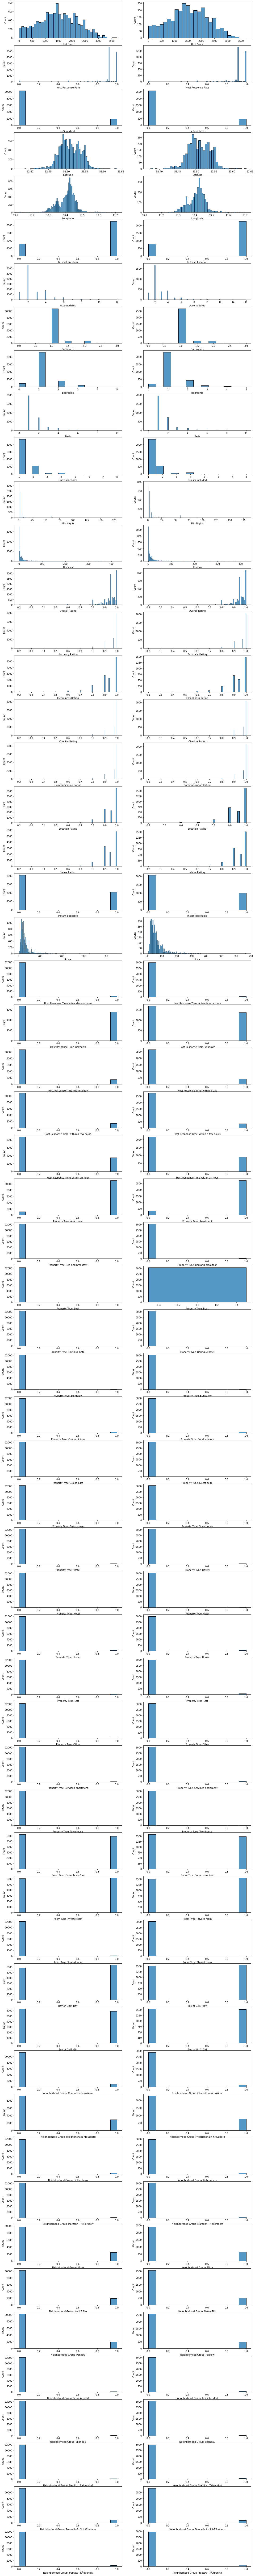

In [9]:
fig = plt.figure(figsize=(18, 200))
gs = GridSpec(len(data.columns), 2)

for index, feature in enumerate(data.columns):
    ax = fig.add_subplot(gs[index, 0])
    sb.histplot(train_set, x=feature, ax=ax)
    ax = fig.add_subplot(gs[index, 1])
    sb.histplot(test_set, x=feature, ax=ax)

plt.plot()

# All variables seem very alicke in both train and test sets so there is no need to stratify

We can see that all variable distributions very alicke in both train and test sets. We conclude that there is no need to stratify, so we keep our train/test split as is.

In [10]:
# If you want to you can check for specific variable proportions with this code

def feature_proportions(data, feature):
    return data[feature].value_counts() / len(data)


compare_props = pd.DataFrame({
    "Input_dataset": feature_proportions(data, 'Boy or Girl?_Boy'),
    "Train_set": feature_proportions(train_set, 'Boy or Girl?_Boy'),
    "Test_set": feature_proportions(test_set, 'Boy or Girl?_Boy')
}).sort_index()
compare_props["Test set. %error"] = 100 * compare_props["Test_set"] / compare_props["Input_dataset"] - 100
compare_props["Train set. %error"] = 100 * compare_props["Train_set"] / compare_props["Input_dataset"] - 100

compare_props

,Input_dataset,Train_set,Test_set,Test set. %error,Train set. %error
0,0.483102,0.480432,0.493779,2.210039,-0.55260
1,0.516898,0.519568,0.506221,-2.065540,0.51647


In [11]:
def create_matrices(train_set, test_set):
        
    X_train = train_set.drop('Price', axis=1)
    y_train = train_set["Price"].copy()

    X_test = test_set.drop("Price", axis=1)
    y_test = test_set["Price"].copy()
    return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = create_matrices(train_set, test_set)

# Standardize data

In [12]:
features = X_train.columns
initial_categorical_features = [
    'Is Superhost', 
    'Is Exact Location', 
    'Instant Bookable',
    'Host Response Time',
    'Property Type',
    'Room Type',
    'Boy or Girl',
    'Neighborhood Group'
]
numerical_features = []
categorical_features = []

for feature in features:
    for initial_categorical_feature in initial_categorical_features:
        if initial_categorical_feature in feature:
            categorical_features.append(feature)
    if feature not in categorical_features:
        numerical_features.append(feature)

In [13]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Xgboost

### Gridsearch for the best parameters

In [14]:
# 1) look for best n_estimators at fixed learning rate eta

pgrid = {
    'n_estimators': [45, 46, 47],     # In reality I tried more values, this is just the final iteration of the search process
    'eta': [0.1]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid=pgrid, cv=10)
grid_search.fit(X_train, y_train)
print('n_estimators = ' + str(grid_search.best_estimator_.n_estimators))
print('Score = ' + str(grid_search.best_estimator_.score(X_test, y_test)))

n_estimators = 46
Score = 0.469555111546051


In [15]:
# 2) given best eta and n_estimators, look for the best max_depth and min_child_weight combo

pgrid = {
    'n_estimators': [46],
    'eta': [0.1],
    'max_depth':[2, 3, 4, 5],              # Same as above, this is just the end of the search process
    'min_child_weight':[1, 2, 3, 4]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid=pgrid, cv=10)
grid_search.fit(X_train, y_train)
print('max_depth = ' + str(grid_search.best_estimator_.max_depth))
print('min_child_weight = ' + str(grid_search.best_estimator_.min_child_weight))
print('Score = ' + str(grid_search.best_estimator_.score(X_test, y_test)))

max_depth = 4
min_child_weight = 2
Score = 0.4898391216297757


In [16]:
# 3) given best eta, n_estimators, max_depth and min_child_weight, search for best gamma

pgrid = {
    'n_estimators': [46],
    'eta': [0.1],
    'max_depth':[4],
    'min_child_weight':[2],
    'gamma':[i/10.0 for i in range(0,5)]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid=pgrid, cv=10)
grid_search.fit(X_train, y_train)
print('gamma = ' + str(grid_search.best_estimator_.gamma))
print('Score = ' + str(grid_search.best_estimator_.score(X_test, y_test)))

gamma = 0.0
Score = 0.4898391216297757


### Best subset selection

In [17]:
def forward(features):

    # build folds object
    kf_4 = KFold(n_splits=4, shuffle=True, random_state=42)  # only 4 folds because this is computationnaly intensive
    
    # Pull out features we still need to process
    remaining_features = [d for d in X_train.columns if d not in features]
    
    results = []
    
    for d in remaining_features:
        model = XGBRegressor(
            n_estimators=46,
            eta=0.1,
            max_depth=4,
            min_child_weight=2,
            gamma=0
        )
        MSE = -1*cross_val_score(
            XGBRegressor(n_estimators=46, eta=0.1, max_depth=4, min_child_weight=2, gamma=0), 
            X_train[features+[d]], 
            y_train, 
            cv=kf_4, 
            scoring='neg_mean_squared_error'
        ).mean()
        model = XGBRegressor(
            n_estimators=46,
            eta=0.1,
            max_depth=4,
            min_child_weight=2,
            gamma=0
        )
        model = model.fit(X_train[features+[d]], y_train)
        results.append({"model":model, "features":features+[d], "MSE":MSE})
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['MSE'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [18]:
'''
# Build best models acording to forward stepwise selection

models_fwd = pd.DataFrame(columns=["MSE", "features", "model"])

tic = time.time()
features = []

for i in range(1,len(X_train.columns)+1):  
    model = forward(features)
    models_fwd.loc[i] = model
    features = model["features"]
    print('Model with '+str(i)+' features done')

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")
'''

'\n# Build best models acording to forward stepwise selection\n\nmodels_fwd = pd.DataFrame(columns=["MSE", "features", "model"])\n\ntic = time.time()\nfeatures = []\n\nfor i in range(1,len(X_train.columns)+1):  \n    model = forward(features)\n    models_fwd.loc[i] = model\n    features = model["features"]\n    print(\'Model with \'+str(i)+\' features done\')\n\ntoc = time.time()\nprint("Total elapsed time:", (toc-tic), "seconds.")\n'

The above cell takes some time, so I saved the resulting models_fwd object in a csv file models_fwd.to_json(r'../../data/models_fwd_xgb.json'). We will simply import it back here.

In [19]:
# Pull models_fwd directly from data to avoid rerunning the above cell
models_fwd = pd.read_json('../../data/models_fwd_xgb.json', dtype={"MSE":np.float})

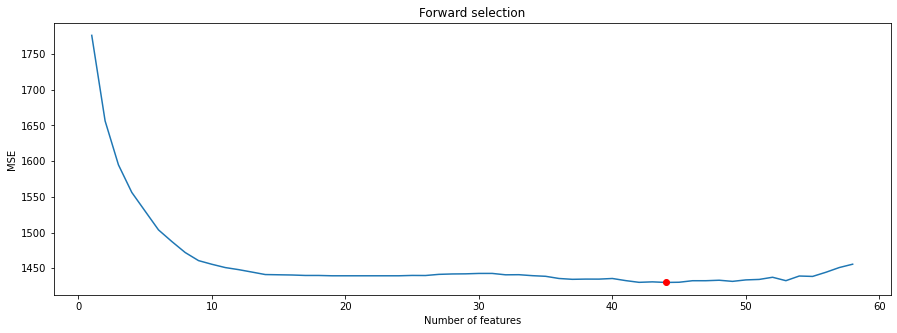

Minimum cross validation MSE achieved for forward selection: 44


In [20]:
# Plot RSS of all selected models in order to chose the best feature subset possible

fig = plt.figure(figsize=(15,5))

plt.plot(models_fwd["MSE"])
plt.xlabel('Number of features')
plt.ylabel('MSE')
plt.title('Forward selection')
plt.plot(models_fwd["MSE"].argmin()+1, models_fwd["MSE"].min(), "or")

plt.show()

print('Minimum cross validation MSE achieved for forward selection: ' + str(models_fwd["MSE"].argmin()+1))

To maximise performance we would take 44 features. But because the the RSS is pretty stable after 15 features, we will choose to only keep 15. Doing this garantees a simpler model with very similar performance as the "big" 44 feature model.
We will still train both models to compare their performance.

In [21]:
# Which features were chosen ?
print('For the 15 feature model we will use :')
print(models_fwd.loc[15, "features"])
print('')
print('For the 44 feature model we will use :')
print(models_fwd.loc[44, "features"])

For the 15 feature model we will use :
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Latitude', 'Property Type_Apartment', 'Bedrooms', 'Property Type_Hotel', 'Guests Included', 'Longitude', 'Property Type_House', 'Host Response Time_unknown', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Instant Bookable', 'Property Type_Other']

For the 44 feature model we will use :
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Latitude', 'Property Type_Apartment', 'Bedrooms', 'Property Type_Hotel', 'Guests Included', 'Longitude', 'Property Type_House', 'Host Response Time_unknown', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Instant Bookable', 'Property Type_Other', 'Host Response Time_within a few hours', 'Neighborhood Group_NeukÃ¶lln', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Host Response Time_a few days or more', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Neighborhood Group_Reinickendorf'

### Training

In [22]:
features_15 = models_fwd.loc[15, "features"]



xgb_15 = XGBRegressor(
    n_estimators=46,
    eta=0.1,
    max_depth=4,
    min_child_weight=2,
    gamma=0
)
xgb_15.fit(X_train[features_15], y_train)
y_pred_15 = xgb_15.predict(X_test[features_15])

In [23]:
features_44 = models_fwd.loc[44, "features"]

xgb_44 = XGBRegressor(
    n_estimators=46,
    eta=0.1,
    max_depth=4,
    min_child_weight=2,
    gamma=0
)
xgb_44.fit(X_train[features_44], y_train)
y_pred_44 = xgb_44.predict(X_test[features_44])

In [38]:
features_full = models_fwd.loc[58, "features"]

xgb_full = XGBRegressor(
    n_estimators=46,
    eta=0.1,
    max_depth=4,
    min_child_weight=2,
    gamma=0
)
xgb_full.fit(X_train, y_train)
y_pred_full = xgb_full.predict(X_test)

### Testing the 15 features model

In [26]:
MSE = mean_squared_error(y_pred_15, y_test) 
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_pred_15, y_test)
adj_rsquared = 1 - (1-xgb_15.score(X_test[features_15], y_test))*(len(y_test)-1)/(len(y_test)-X_test[features_15].shape[1]-1)

print('Model MSE on test set: '+str(MSE))
print('Model RMSE on test set: '+str(RMSE))
print('Model MAE on test set: '+str(MAE))
print('Model adjusted R-square on test set: '+str(adj_rsquared))

Model MSE on test set: 1023.525696457521
Model RMSE on test set: 31.99258814878098
Model MAE on test set: 19.657280744566354
Model adjusted R-square on test set: 0.48055920601712554


<AxesSubplot:ylabel='Count'>

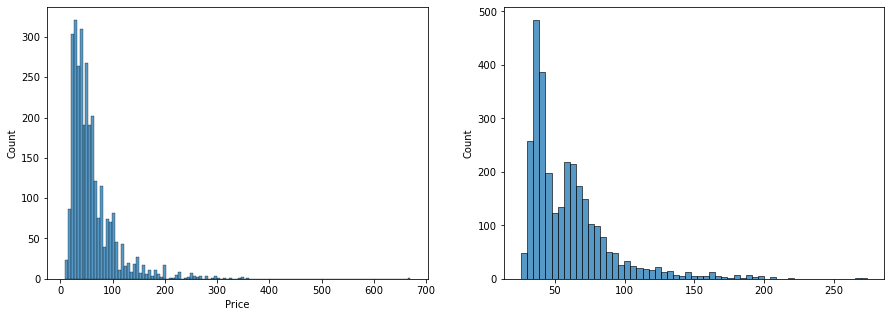

In [27]:
# Prediction distribution against real distribution

fig = plt.figure(figsize=(15,5)) 
(ax1, ax2) = fig.subplots(1, 2)

sb.histplot(y_test, ax=ax1)
sb.histplot(y_pred_15, ax=ax2)

In [28]:
# Importance of each feature in the predictions

correlations = {}

for feature in features_15:
    correlations[pearsonr(X_test[feature], y_pred_15)[0]] = feature
sorted_correlations = sorted(correlations.keys(), reverse=True)

print('Correlations in order :')
print(' ')
for r in sorted_correlations:
    print('Between the prediction and '+ correlations[r] + ' : r=' + str(r))

Correlations in order :
 
Between the prediction and Accomodates : r=0.7846746270922507
Between the prediction and Bedrooms : r=0.655093525911876
Between the prediction and Room Type_Entire home/apt : r=0.6443589318153073
Between the prediction and Guests Included : r=0.5311294337104399
Between the prediction and Bathrooms : r=0.4044742845880782
Between the prediction and Property Type_Hotel : r=0.1248692188770185
Between the prediction and Location Rating : r=0.0990649056197268
Between the prediction and Latitude : r=0.08520384426117053
Between the prediction and Neighborhood Group_Charlottenburg-Wilm. : r=0.0701877534141141
Between the prediction and Property Type_House : r=0.03186247851729859
Between the prediction and Instant Bookable : r=0.029956233895188956
Between the prediction and Property Type_Other : r=-0.022910152358520283
Between the prediction and Longitude : r=-0.040115620581667705
Between the prediction and Host Response Time_unknown : r=-0.20879129604017424
Between the

Testing results are discussed in the report.

### Testing the 44 features model

In [29]:
MSE = mean_squared_error(y_pred_44, y_test) 
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_pred_44, y_test)
adj_rsquared = 1 - (1-xgb_44.score(X_test[features_44], y_test))*(len(y_test)-1)/(len(y_test)-X_test[features_44].shape[1]-1)

print('Model MSE on test set: '+str(MSE))
print('Model RMSE on test set: '+str(RMSE))
print('Model MAE on test set: '+str(MAE))
print('Model adjusted R-square on test set: '+str(adj_rsquared))

Model MSE on test set: 1021.8354400132727
Model RMSE on test set: 31.966160858214938
Model MAE on test set: 19.654199820058206
Model adjusted R-square on test set: 0.476419038701424


<AxesSubplot:ylabel='Count'>

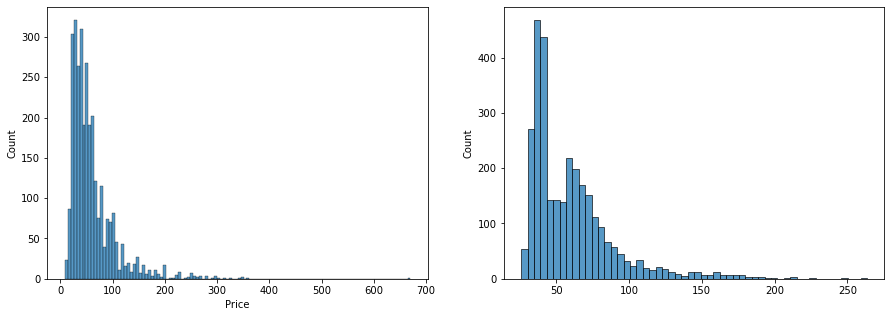

In [30]:
# Prediction distribution against real distribution

fig = plt.figure(figsize=(15,5)) 
(ax1, ax2) = fig.subplots(1, 2)

sb.histplot(y_test, ax=ax1)
sb.histplot(y_pred_44, ax=ax2)

In [31]:
# Importance of each feature in the predictions

correlations = {}

for feature in features_44:
    correlations[pearsonr(X_test[feature], y_pred_44)[0]] = feature
sorted_correlations = sorted(correlations.keys(), reverse=True)

print('Correlations in order :')
print(' ')
for r in sorted_correlations:
    print('Between the prediction and '+ correlations[r] + ' : r=' + str(r))

Correlations in order :
 
Between the prediction and Accomodates : r=0.7872003994788425
Between the prediction and Bedrooms : r=0.6527555353860169
Between the prediction and Room Type_Entire home/apt : r=0.6502111555606033
Between the prediction and Guests Included : r=0.5357176006876756
Between the prediction and Bathrooms : r=0.4011830925967885
Between the prediction and Host Response Time_within an hour : r=0.14919457267927552
Between the prediction and Property Type_Hotel : r=0.11733237859730863
Between the prediction and Is Superhost : r=0.10410893995167717
Between the prediction and Location Rating : r=0.09370387752073356
Between the prediction and Latitude : r=0.09177980860705859
Between the prediction and Neighborhood Group_Mitte : r=0.08244215973780887
Between the prediction and Neighborhood Group_Charlottenburg-Wilm. : r=0.07049275237254823
Between the prediction and Neighborhood Group_Pankow : r=0.06595138908452466
Between the prediction and Host Response Time_within a few h

Testing results are discussed in the report.

### Testing the full features model

In [35]:
MSE = mean_squared_error(y_pred_full, y_test) 
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_pred_full, y_test)
adj_rsquared = 1 - (1-xgb_full.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

print('Model MSE on test set: '+str(MSE))
print('Model RMSE on test set: '+str(RMSE))
print('Model MAE on test set: '+str(MAE))
print('Model adjusted R-square on test set: '+str(adj_rsquared))

Model MSE on test set: 1010.2035334956705
Model RMSE on test set: 31.78369917891356
Model MAE on test set: 19.58925652582035
Model adjusted R-square on test set: 0.47995954535415863


<AxesSubplot:ylabel='Count'>

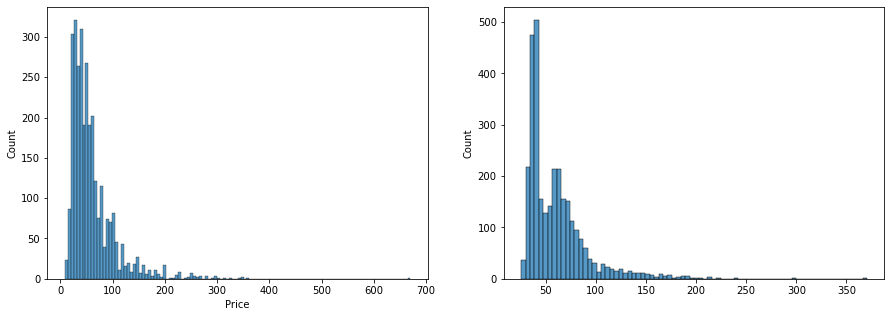

In [36]:
# Prediction distribution against real distribution

fig = plt.figure(figsize=(15,5)) 
(ax1, ax2) = fig.subplots(1, 2)

sb.histplot(y_test, ax=ax1)
sb.histplot(y_pred_full, ax=ax2)

In [37]:
# Importance of each feature in the predictions

correlations = {}

for feature in features_full:
    correlations[pearsonr(X_test[feature], y_pred_full)[0]] = feature
sorted_correlations = sorted(correlations.keys(), reverse=True)

print('Correlations in order :')
print(' ')
for r in sorted_correlations:
    print('Between the prediction and '+ correlations[r] + ' : r=' + str(r))

Correlations in order :
 
Between the prediction and Accomodates : r=0.7843588205839863
Between the prediction and Guests Included : r=0.5364037507995436
Between the prediction and Property Type_Boat : r=nan
Between the prediction and Beds : r=0.6833396628185171
Between the prediction and Bedrooms : r=0.6516631989766493
Between the prediction and Room Type_Entire home/apt : r=0.6407815069715361
Between the prediction and Bathrooms : r=0.39419190613956534
Between the prediction and Property Type_Loft : r=0.22123063480260508
Between the prediction and Property Type_Serviced apartment : r=0.18539584500429585
Between the prediction and Host Response Time_within an hour : r=0.15356182710032681
Between the prediction and Is Superhost : r=0.10550809492140661
Between the prediction and Property Type_Hotel : r=0.10522565818826257
Between the prediction and Reviews : r=0.09931910089026098
Between the prediction and Latitude : r=0.09520221575898756
Between the prediction and Location Rating : r=0

An input array is constant; the correlation coefficent is not defined.


# Feature analysis using shapley values
From now on we use the full feature model as it is the most performant in most metrics.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


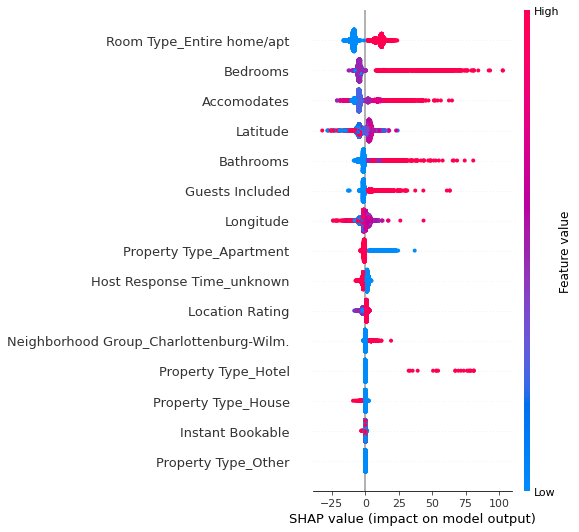

In [39]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_15)
shap_values = explainer.shap_values(X_train[features_15])
shap.summary_plot(shap_values, X_train[features_15], features_15)

Here the shap values are measured on the train set. This means that the summary plot shows how the training features drive the model. 